In [1]:
import wave
from wave_audio import info, write
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import arviz as az
import pickle
from sklearn.preprocessing import StandardScaler
plt.style.use('seaborn-darkgrid')
plt.rcParams['font.family'] = 'Noto Sans CJK JP'
plt.rcParams['font.size'] = 17
import warnings
warnings.filterwarnings('ignore')

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### リファレンス音声を読み込む

In [2]:
audio = wave.open('arp_white.wav','r')
buf = audio.readframes(audio.getnframes())
audio_data = np.frombuffer(buf, dtype='int16')

In [3]:
info(audio)

サンプリングレートは48000Hz
ビット深度は16ビット
チャンネル数は1ch
サンプリング数は288000
6.0秒分のデータ


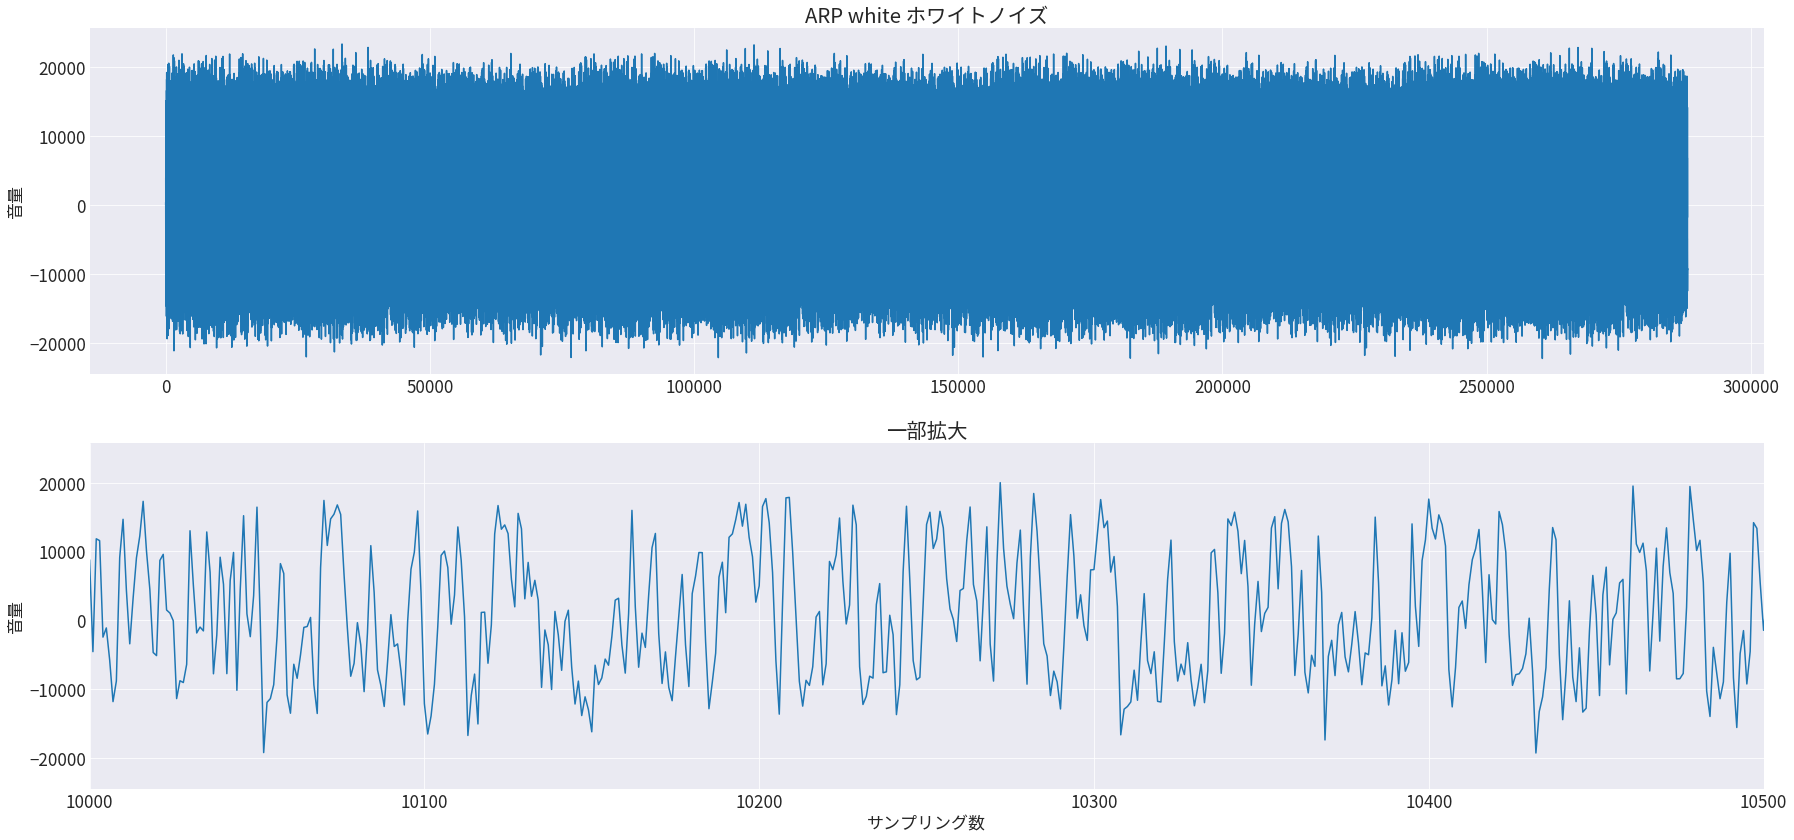

In [4]:
plt.figure(figsize=(30, 14))
plt.subplot(211)
plt.plot(audio_data)
plt.title('ARP white ホワイトノイズ')
plt.ylabel('音量')
plt.subplot(212)
plt.plot(audio_data)
plt.title('一部拡大')
plt.xlabel('サンプリング数')
plt.xlim(10000, 10500)
plt.ylabel('音量')
plt.savefig('data_folder/arp_white_plot.png', bbox_inches='tight', pad_inches=0.3)
plt.show()

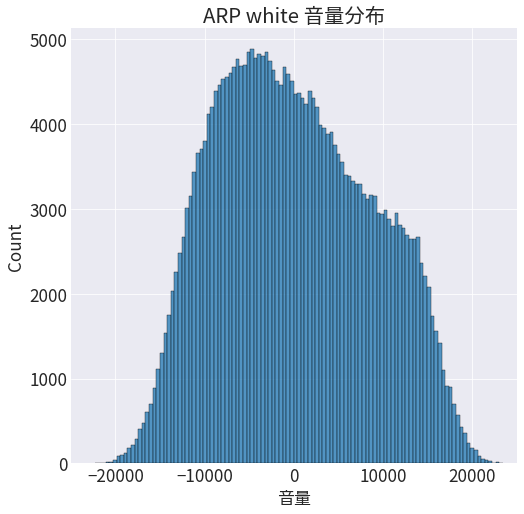

In [5]:
plt.figure(figsize=(8, 8))
sns.histplot(audio_data)
plt.title('ARP white 音量分布')
plt.xlabel('音量')
plt.xlim(-25000, 25000)
plt.savefig('data_folder/arp_white_distribution.png', bbox_inches='tight', pad_inches=0.3)
plt.show()

一部データを標準化して使用

In [6]:
# ランダムに5000個のデータを取り出す
rng = np.random.default_rng()
obs = rng.choice(audio_data, 5000, replace=False)

# 標準化
scaler = StandardScaler()
scaler.fit(obs.reshape(-1, 1))
obs_standard = scaler.transform(obs.reshape(-1, 1)).reshape(-1)
# 標準化データ保存
pickle.dump(scaler, open('data_folder/obs_standard_data.pkl', 'wb'))

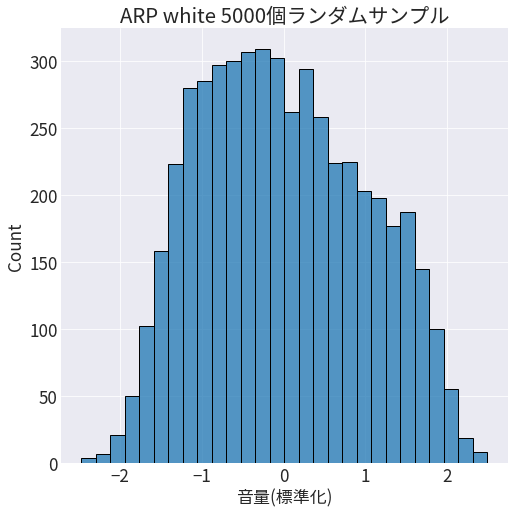

In [7]:
plt.figure(figsize=(8, 8))
sns.histplot(obs_standard)
plt.title('ARP white 5000個ランダムサンプル')
plt.xlabel('音量(標準化)')
plt.savefig('data_folder/ランダムサンプル.png', bbox_inches='tight', pad_inches=0.3)
plt.show()

分布を正規混合モデルとしてパラメータ探索

In [9]:
estimate_shape = 3
with pm.Model() as model:
    w = pm.Dirichlet('w', np.ones(estimate_shape))
    
    mu = pm.Normal('mu', mu=np.zeros(estimate_shape), sigma=1.0, shape=estimate_shape, transform=pm.transforms.ordered, initval=[-1.0, 0.0, 1.5])
    tau = pm.Gamma('tau', alpha=1.0, beta=1.0, shape=estimate_shape)
    
    x_obs = pm.NormalMixture('x_obs', w, mu, tau=tau, observed=obs_standard)

cores = 1で試す

cores = 16

In [14]:
with model:
    trace = pm.sample(5000, n_init=10000, tune=2000, return_inferencedata=True, cores=16)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (16 chains in 16 jobs)
NUTS: [tau, mu, w]


Sampling 16 chains for 2_000 tune and 5_000 draw iterations (32_000 + 80_000 draws total) took 348 seconds.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [16]:
with model:
    ppc_trace = pm.sample_posterior_predictive(trace, model=model, var_names=['x_obs'], keep_size=True, progressbar=True)
trace.add_groups(posterior_predictive=ppc_trace)

In [26]:
# traceデータ保存
with open('data_folder/audio_trace.pkl', 'wb') as f:
    pickle.dump(trace, f)